# Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import ruptures as rpt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input# Define the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from skopt import gp_minimize
from skopt.space import Real, Integer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

2024-11-10 12:58:22.638531: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-10 12:58:22.704801: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-10 12:58:22.744374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731223702.847403   17571 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731223702.858100   17571 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 12:58:22.923243: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Data Preparation - Variables

In [3]:
file_path = 'dataset.csv'  # Ensure this path points to your dataset file
exchange_data = pd.read_csv(file_path)

In [4]:
print(exchange_data.head(10))

         Date   Price    Open    High     Low  Vol. Change %
0  17-10-2024  84.021  84.040  84.088  84.018   NaN   -0.01%
1  16-10-2024  84.030  84.052  84.102  83.975   NaN   -0.01%
2  15-10-2024  84.040  84.065  84.087  84.015   NaN   -0.01%
3  14-10-2024  84.045  84.070  84.105  84.022   NaN   -0.07%
4  11-10-2024  84.101  83.965  84.121  83.942   NaN    0.19%
5  10-10-2024  83.940  83.939  83.992  83.931   NaN   -0.01%
6  09-10-2024  83.950  83.917  83.965  83.888   NaN    0.01%
7  08-10-2024  83.945  83.942  83.988  83.905   NaN   -0.04%
8  07-10-2024  83.980  83.978  83.997  83.934   NaN   -0.05%
9  04-10-2024  84.023  83.972  84.023  83.924   NaN    0.04%


In [5]:
# 1. Convert 'Date' column to datetime format and set as index
exchange_data['Date'] = pd.to_datetime(exchange_data['Date'], format='%d-%m-%Y')

# 2. Sort by date if you plan on doing time series analysis
exchange_data = exchange_data.sort_values(by='Date').reset_index(drop=True)

# 3. Set 'Date' as the index and create a new series with only 'Price' column
exchange_data = exchange_data.set_index('Date')

In [6]:
print(exchange_data.head(10))

             Price    Open    High     Low  Vol. Change %
Date                                                     
2006-01-02  45.075  45.105  45.145  45.062   NaN    0.18%
2006-01-03  44.965  45.125  45.145  44.965   NaN   -0.24%
2006-01-04  44.705  44.885  44.900  44.665   NaN   -0.58%
2006-01-05  44.600  44.650  44.765  44.600   NaN   -0.23%
2006-01-06  44.320  44.570  44.785  44.310   NaN   -0.63%
2006-01-09  44.250  44.320  44.375  44.220   NaN   -0.16%
2006-01-10  44.185  44.205  44.460  44.165   NaN   -0.15%
2006-01-11  43.915  44.145  44.145  43.915   NaN   -0.61%
2006-01-12  44.020  43.950  44.230  43.930   NaN    0.24%
2006-01-13  44.100  44.060  44.335  44.010   NaN    0.18%


In [7]:
# 4. Ensure 'Price', 'Open', 'High', and 'Low' are in numeric format
cols_to_convert = ['Price', 'Open', 'High', 'Low']
exchange_data[cols_to_convert] = exchange_data[cols_to_convert].apply(pd.to_numeric, errors='coerce')


In [8]:
# 5. Remove '%' from 'Change %' and convert to numeric
exchange_data['Change %'] = exchange_data['Change %'].str.replace('%', '').astype(float)


In [9]:
# 6. Find and print dates where 'Price' in price_series is null
null_price_dates = exchange_data[exchange_data['Price'].isnull()].index
print(null_price_dates)

# 7. Fill missing values if necessary (e.g., forward-fill)
exchange_data['Price'] = exchange_data['Price'].ffill()


DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)


In [10]:
print(exchange_data.head(10))

             Price    Open    High     Low  Vol.  Change %
Date                                                      
2006-01-02  45.075  45.105  45.145  45.062   NaN      0.18
2006-01-03  44.965  45.125  45.145  44.965   NaN     -0.24
2006-01-04  44.705  44.885  44.900  44.665   NaN     -0.58
2006-01-05  44.600  44.650  44.765  44.600   NaN     -0.23
2006-01-06  44.320  44.570  44.785  44.310   NaN     -0.63
2006-01-09  44.250  44.320  44.375  44.220   NaN     -0.16
2006-01-10  44.185  44.205  44.460  44.165   NaN     -0.15
2006-01-11  43.915  44.145  44.145  43.915   NaN     -0.61
2006-01-12  44.020  43.950  44.230  43.930   NaN      0.24
2006-01-13  44.100  44.060  44.335  44.010   NaN      0.18


In [11]:
# Create Training and Testing Datasets
train_size = -30    #  a week
train, test = exchange_data[:train_size], exchange_data[train_size:]

In [12]:
print(type(train), type(test), len(train), len(test))
print(train.head(10))
print(test.head(10))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> 4874 30
             Price    Open    High     Low  Vol.  Change %
Date                                                      
2006-01-02  45.075  45.105  45.145  45.062   NaN      0.18
2006-01-03  44.965  45.125  45.145  44.965   NaN     -0.24
2006-01-04  44.705  44.885  44.900  44.665   NaN     -0.58
2006-01-05  44.600  44.650  44.765  44.600   NaN     -0.23
2006-01-06  44.320  44.570  44.785  44.310   NaN     -0.63
2006-01-09  44.250  44.320  44.375  44.220   NaN     -0.16
2006-01-10  44.185  44.205  44.460  44.165   NaN     -0.15
2006-01-11  43.915  44.145  44.145  43.915   NaN     -0.61
2006-01-12  44.020  43.950  44.230  43.930   NaN      0.24
2006-01-13  44.100  44.060  44.335  44.010   NaN      0.18
             Price    Open    High     Low  Vol.  Change %
Date                                                      
2024-09-06  83.985  83.983  83.985  83.891   NaN      0.03
2024-09-09  83.928  83.940  83.

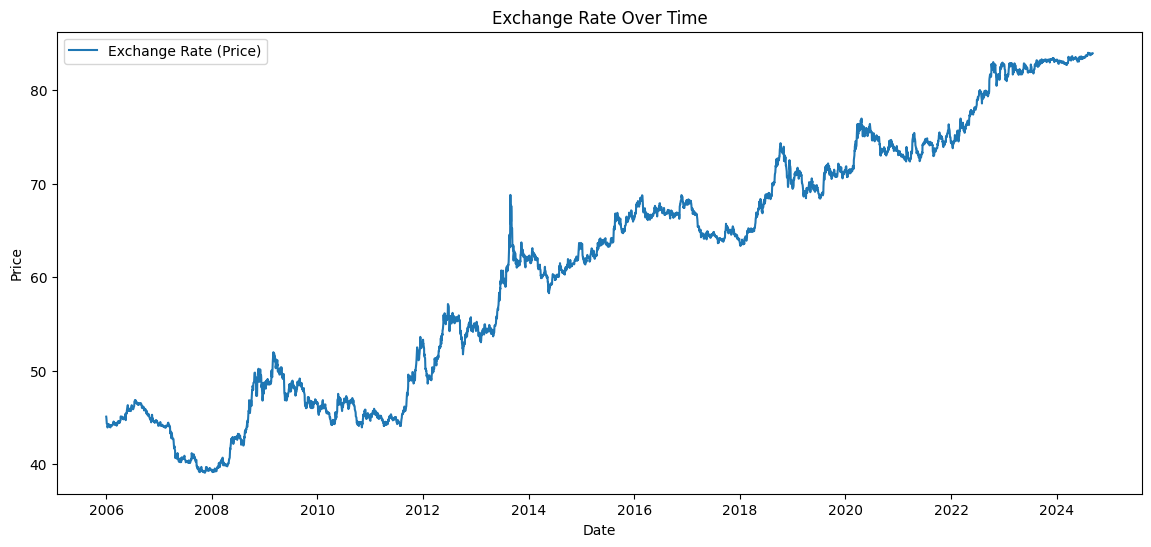

In [13]:
# Plot the time series data
plt.figure(figsize=(14, 6))
plt.plot(train['Price'], label='Exchange Rate (Price)')
plt.title('Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Stationarity test

In [161]:
summary = train['Price'].describe()
print(summary)

count    4874.000000
mean       61.272127
std        13.401297
min        39.075000
25%        47.057500
50%        63.517000
75%        72.388000
max        84.018000
Name: Price, dtype: float64


In [162]:
def is_stationary(series, significance_level=0.05):
    # Perform the Augmented Dickey-Fuller test
    result = adfuller(series.dropna())
    
    # Extract test statistic and p-value
    adf_statistic, p_value = result[0], result[1]
    
    # Display test results
    print('ADF Statistic:', adf_statistic)
    print('p-value:', p_value)
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')
    
    # Check stationarity based on the p-value
    if p_value < significance_level:
        print("The time series is stationary.")
        return True
    else:
        print("The time series is not stationary.")
        return False


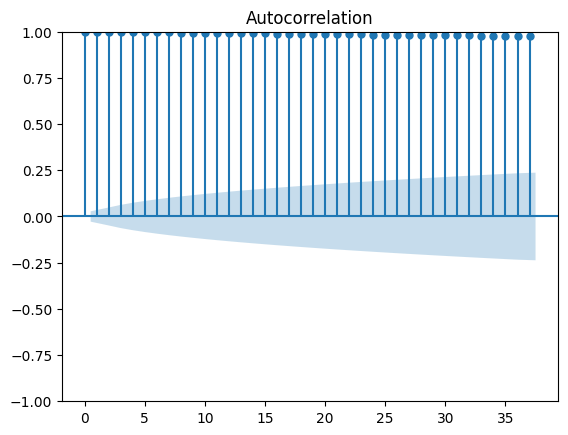

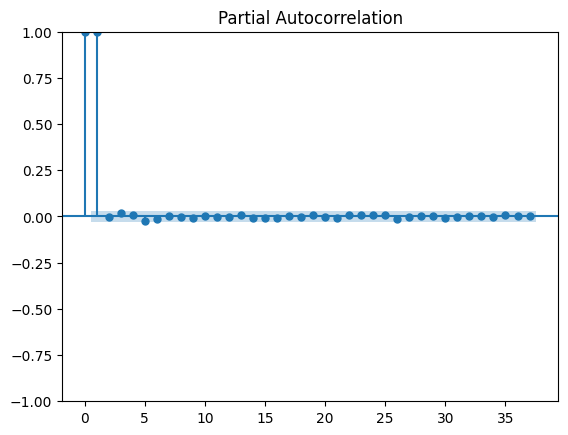

In [163]:
plot_acf(train['Price'])
plot_pacf(train['Price'])
plt.show()

In [164]:
price_stationary = is_stationary(train['Price'])

ADF Statistic: -0.20288440381782616
p-value: 0.9381769297106046
Critical Value (1%): -3.431694032782524
Critical Value (5%): -2.8621339136095614
Critical Value (10%): -2.567086141543486
The time series is not stationary.


In [165]:
# Step 2: De-seasonalize the series using seasonal decomposition
decomposition = seasonal_decompose(train['Price'], model='additive', period=5)  # weekly seasonality
deseasonalized_series = train['Price'] - decomposition.seasonal
# print(deseasonalized_series.shape)

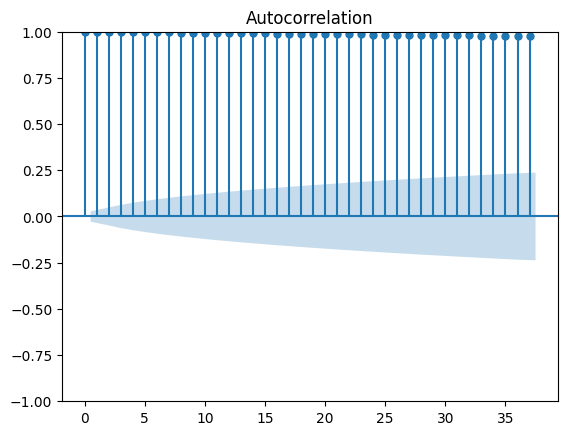

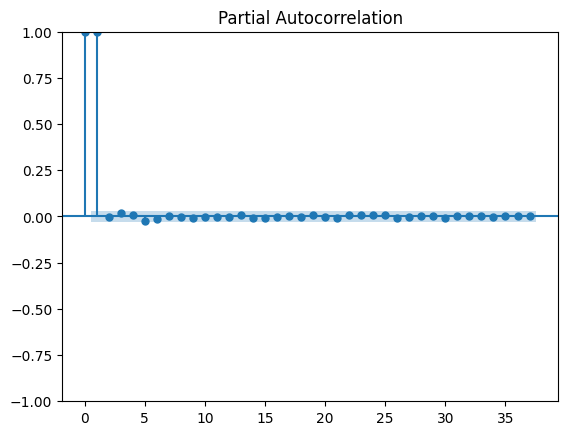

In [166]:
plot_acf(deseasonalized_series)
plot_pacf(deseasonalized_series)
plt.show()

In [167]:
deseasonalized_stationary = is_stationary(deseasonalized_series)

ADF Statistic: -0.19926772556290628
p-value: 0.938608846319916
Critical Value (1%): -3.431694032782524
Critical Value (5%): -2.8621339136095614
Critical Value (10%): -2.567086141543486
The time series is not stationary.


In [168]:
diff_series = train['Price'].diff().dropna()


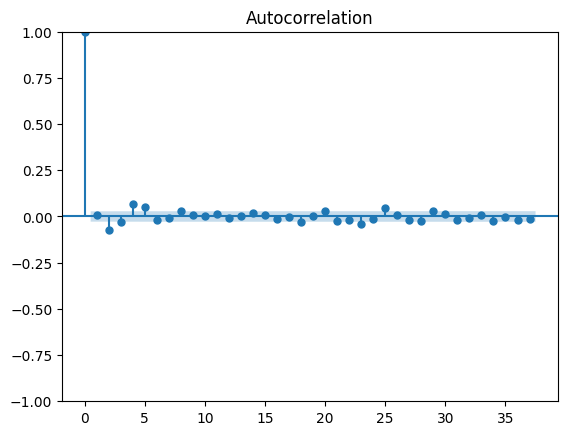

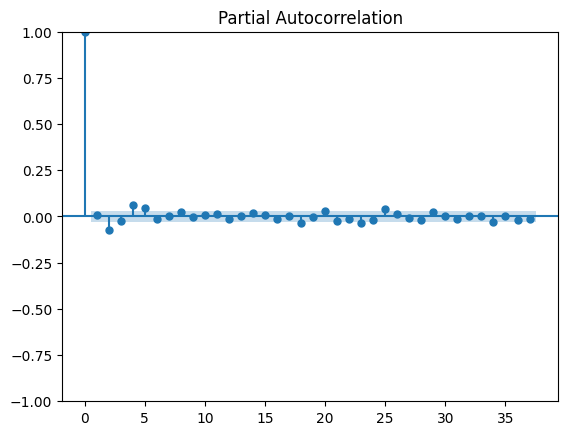

In [169]:
plot_acf(diff_series)
plot_pacf(diff_series)
plt.show()

In [170]:
diff_stationary = is_stationary(diff_series)

ADF Statistic: -29.60734732863659
p-value: 0.0
Critical Value (1%): -3.431694032782524
Critical Value (5%): -2.8621339136095614
Critical Value (10%): -2.567086141543486
The time series is stationary.


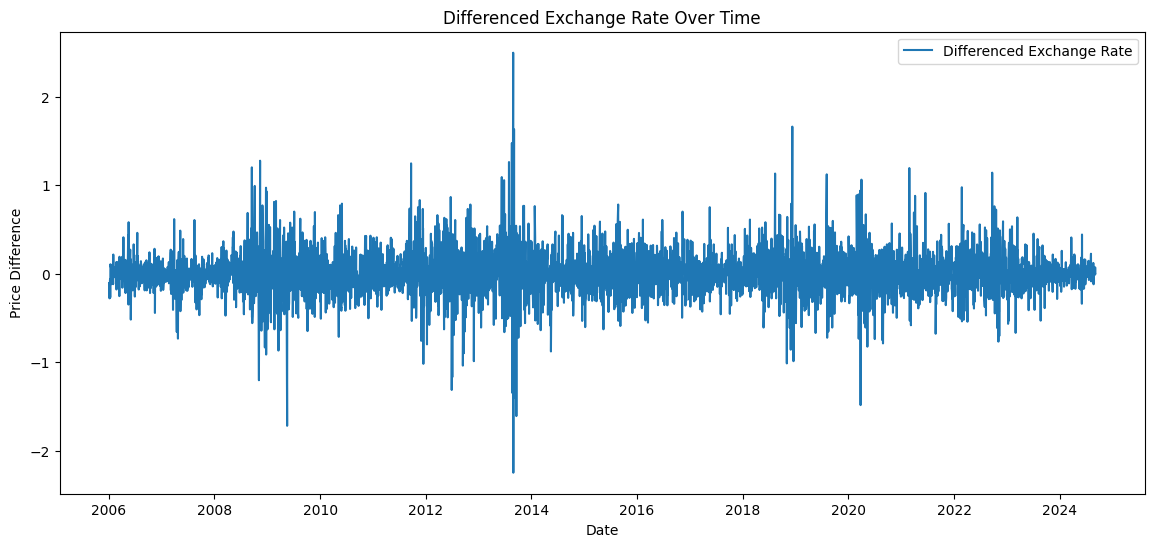

In [171]:
# Plot the differenced series
plt.figure(figsize=(14, 6))
plt.plot(diff_series, label='Differenced Exchange Rate')
plt.title('Differenced Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.show()

In [172]:
# Create a time index
time_index = np.arange(len(train['Price']))

# Fit a linear regression model
X = sm.add_constant(time_index)  # Add constant for intercept
model = sm.OLS(train['Price'], X).fit()

# Get the trend component
trend = model.predict(X)

# Detrended series
detrended_series = train['Price'] - trend

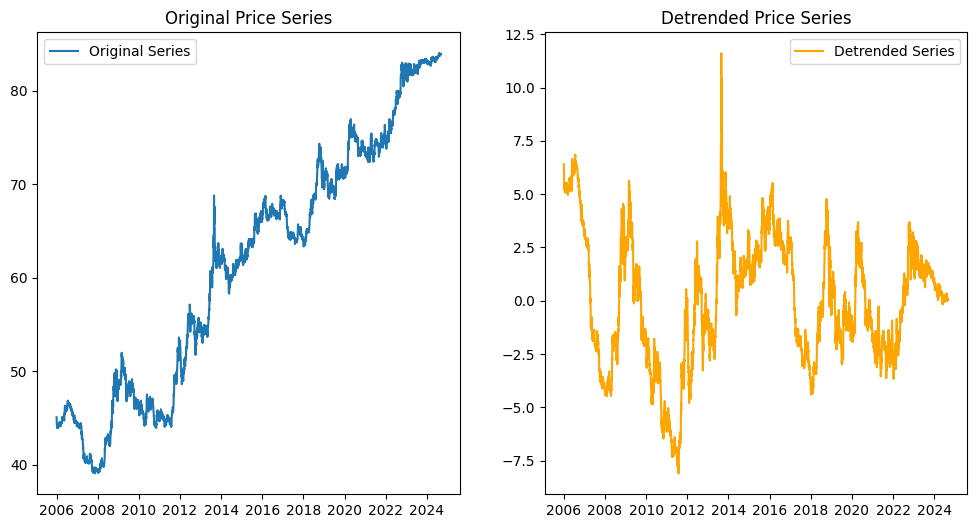

In [173]:
# Plotting the original and detrended series
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train['Price'], label='Original Series')
plt.title('Original Price Series')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(detrended_series, label='Detrended Series', color='orange')
plt.title('Detrended Price Series')
plt.legend()

plt.show()

In [174]:
detrend_stationary = is_stationary(detrended_series)

ADF Statistic: -3.2529556841302703
p-value: 0.01711686399657917
Critical Value (1%): -3.431694032782524
Critical Value (5%): -2.8621339136095614
Critical Value (10%): -2.567086141543486
The time series is stationary.


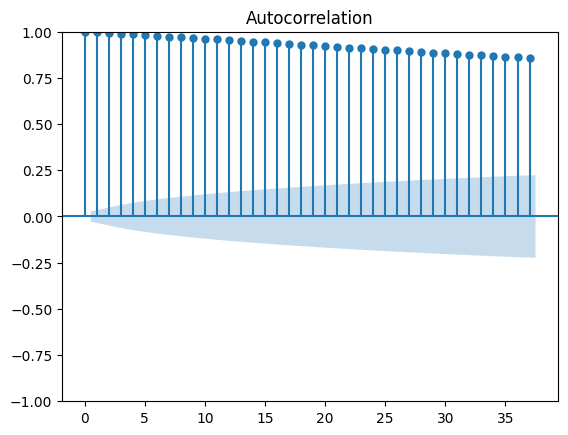

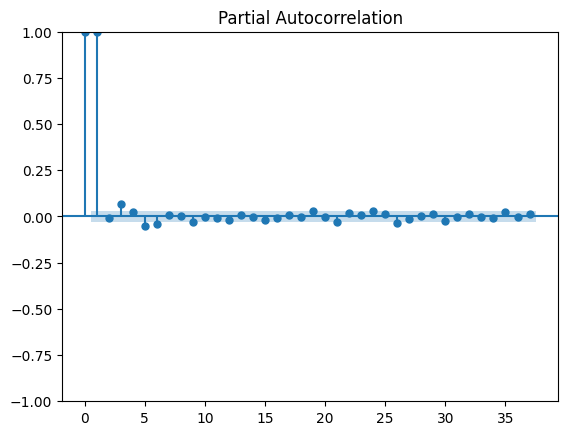

In [175]:
plot_acf(detrended_series)
plot_pacf(detrended_series)
plt.show()

<Figure size 1200x1000 with 0 Axes>

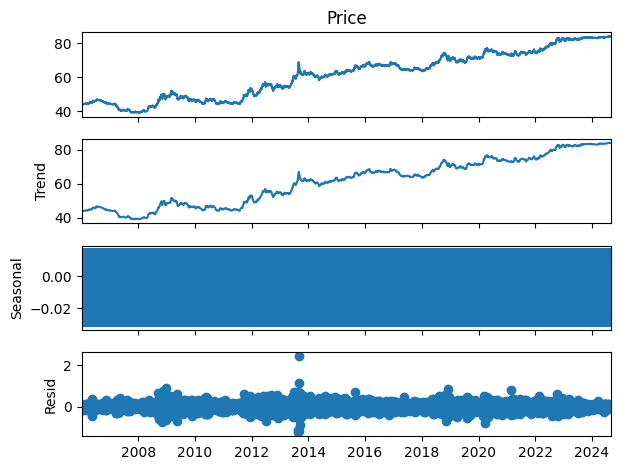

In [176]:
decomposition = seasonal_decompose(train['Price'], model='additive', period=5)
# Plot decomposition
plt.figure(figsize=(12, 10))
decomposition.plot()
plt.show()

# Structural breaks

In [177]:
# Use Bai-Perron test to detect structural breaks
signal = train['Price'].values
model = "l2"  # Model type for detecting changes in mean
algo = rpt.Binseg(model=model).fit(signal)  # Change to Binseg for fast detection
breakpoints = algo.predict(n_bkps=13)  # Set the number of breakpoints to detect, visual inspection
print(breakpoints)
print(len(train['Price']))

[330, 615, 700, 980, 1495, 1650, 1945, 2495, 2920, 3225, 3695, 4300, 4365, 4874]
4874


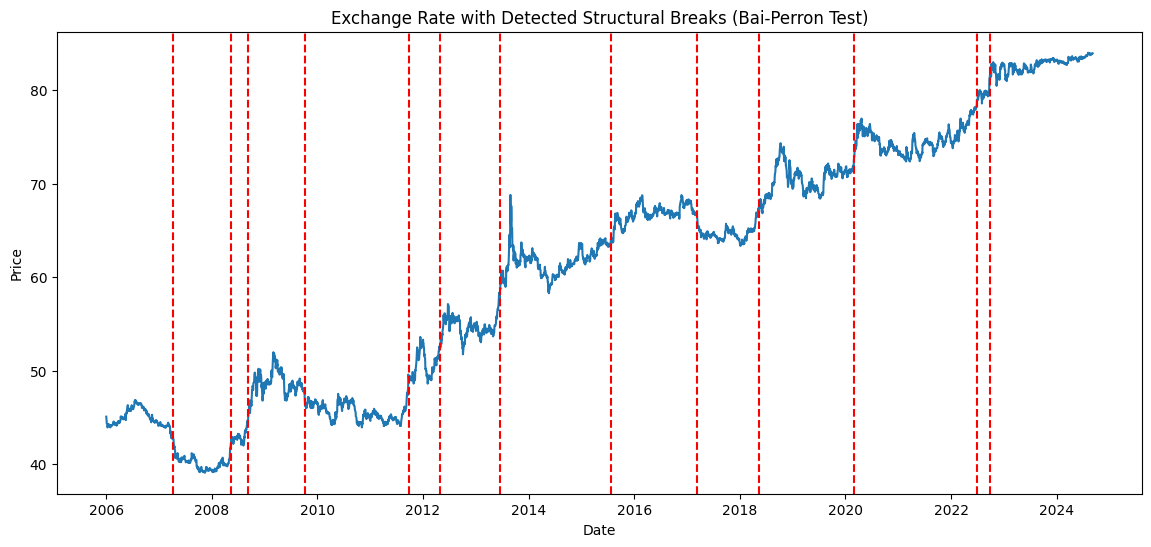

In [178]:
# Plotting the results
plt.figure(figsize=(14, 6))
plt.plot(train.index, train['Price'], label='Exchange Rate')
for breakpoint in breakpoints[:-1]:
    plt.axvline(train.index[breakpoint], color='red', linestyle='--', label='Structural Break')
plt.title('Exchange Rate with Detected Structural Breaks (Bai-Perron Test)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# ARIMA

In [179]:
# Automatically fit SARIMA with optimal parameters
model = pm.auto_arima(train['Price'], trace=True, information_criterion='aic')
print(model.summary())

# Forecasting
forecast = model.predict(n_periods=len(test['Price']))

# Step 4: Evaluate the forecast
test_rmse = root_mean_squared_error(test['Price'], forecast)
test_mae = mean_absolute_error(test['Price'], forecast)
print(f'Test RMSE: {test_rmse}')
print(f'Test MAE: {test_mae}')

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=394.990, Time=6.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=440.783, Time=1.35 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=442.572, Time=0.86 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=442.535, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=443.626, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=421.444, Time=3.94 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=417.691, Time=2.68 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=397.078, Time=6.43 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=396.513, Time=15.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=441.997, Time=2.76 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=418.065, Time=8.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=413.261, Time=4.77 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=394.651, Time=15.25 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=393.529, Time=18.12 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=39

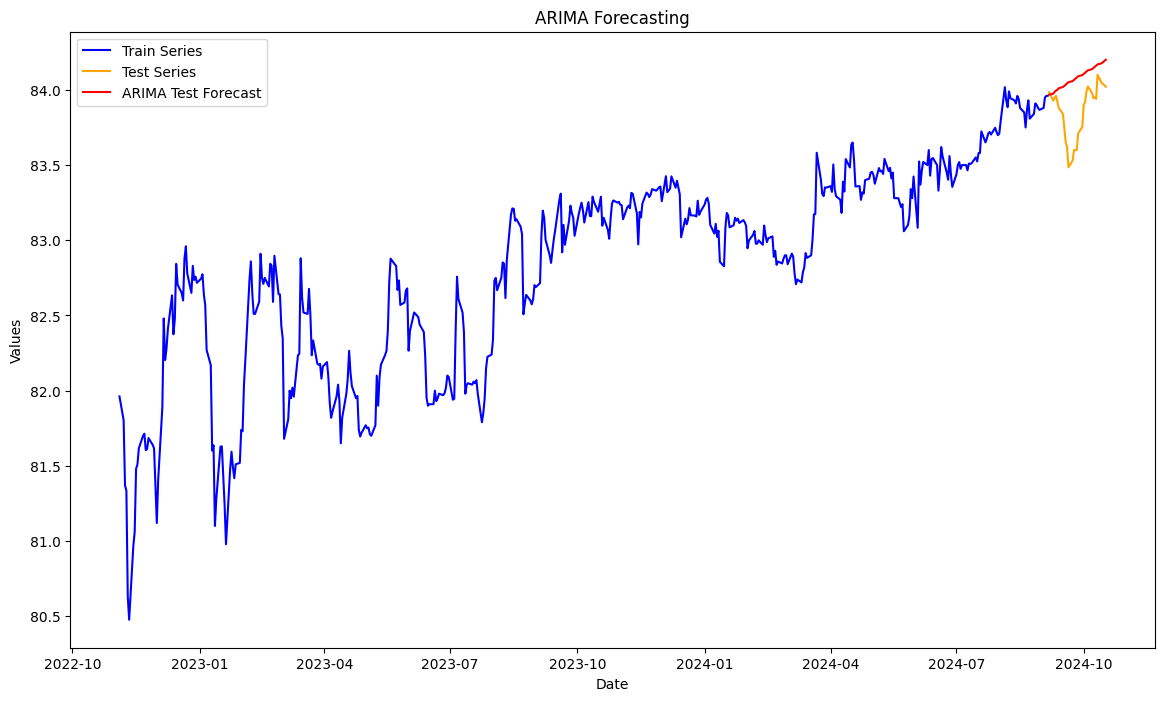

In [180]:
# Step 4: Plotting the Results
plt.figure(figsize=(14, 8))

# Plot the actual train and test series
plt.plot(train['Price'].index[-360:], train['Price'][-360:], label='Train Series', color='blue')
plt.plot(test['Price'].index, test['Price'], label='Test Series', color='orange')

# Forecast for the test period (out-of-sample forecast)
plt.plot(test['Price'].index, forecast, label='ARIMA Test Forecast', color='red')

# Labels and legend
plt.title("ARIMA Forecasting")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.show()

In [181]:
# Automatically fit SARIMA with optimal parameters
model = pm.auto_arima(train['Price'], trace=True, information_criterion='bic')
print(model.summary())

# Forecasting
forecast = model.predict(n_periods=len(test['Price']))

# Step 4: Evaluate the forecast
test_rmse = root_mean_squared_error(test['Price'], forecast)
test_mae = mean_absolute_error(test['Price'], forecast)
print(f'Test RMSE: {test_rmse}')
print(f'Test MAE: {test_mae}')

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=433.938, Time=5.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=453.766, Time=1.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=462.046, Time=0.74 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=462.009, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=450.117, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=453.901, Time=3.85 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : BIC=450.148, Time=2.52 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : BIC=442.519, Time=5.84 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : BIC=441.953, Time=15.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=467.962, Time=2.36 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : BIC=457.014, Time=8.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : BIC=452.210, Time=6.35 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : BIC=446.583, Time=14.50 sec
 ARIMA(2,1,2)(0,0,0)[0]             : BIC=430.925, Time=1.96 sec
 ARIMA(1,1,2)(0,0,0)[0]             : BIC=451

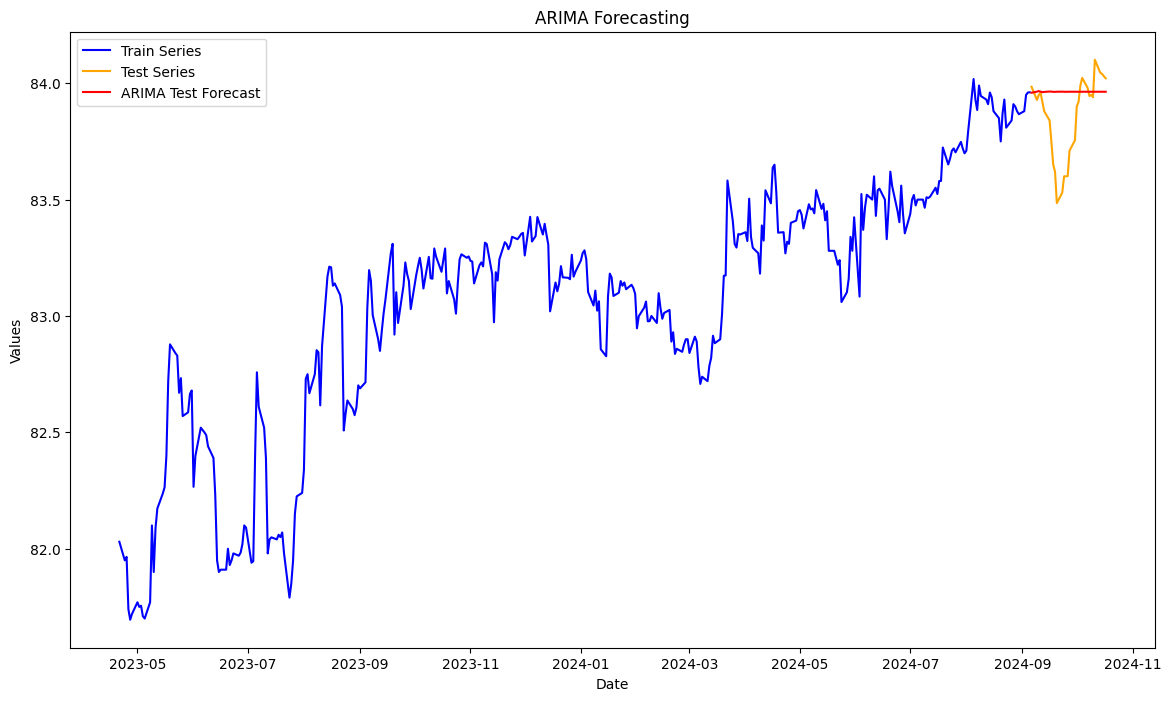

In [184]:
# Step 4: Plotting the Results
plt.figure(figsize=(14, 8))

# Plot the actual train and test series
plt.plot(train['Price'].index[-360:], train['Price'][-360:], label='Train Series', color='blue')
plt.plot(test['Price'].index, test['Price'], label='Test Series', color='orange')

# Forecast for the test period (out-of-sample forecast)
plt.plot(test['Price'].index, forecast, label='ARIMA Test Forecast', color='red')

# Labels and legend
plt.title("ARIMA Forecasting")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.show()

In [87]:
arima_model = SARIMAX(train['Price'], order=(2, 1, 2)).fit()

/home/harsh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/home/harsh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.01333D-02    |proj g|=  1.42007D-02


 This problem is unconstrained.



At iterate    5    f=  4.01100D-02    |proj g|=  5.29896D-03

At iterate   10    f=  4.00342D-02    |proj g|=  1.27071D-02

At iterate   15    f=  3.99144D-02    |proj g|=  1.84686D-03

At iterate   20    f=  3.98824D-02    |proj g|=  1.04078D-02

At iterate   25    f=  3.98512D-02    |proj g|=  1.24077D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     31      1     0     0   1.050D-04   3.985D-02
  F =   3.9851033234405975E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [93]:
arima_model_predictions = arima_model.forecast(steps=30)

# SARIMA - Weekly Seasonality

In [185]:
# Automatically fit SARIMA with optimal parameters
model = pm.auto_arima(train['Price'], seasonal=True, m=5,
                      stepwise=True, trace=True)
print(model.summary())

# Forecasting
forecast = model.predict(n_periods=len(test['Price']))

# Step 4: Evaluate the forecast
test_rmse = root_mean_squared_error(test['Price'], forecast)
test_mae = mean_absolute_error(test['Price'], forecast)
print(f'Test RMSE: {test_rmse}')
print(f'Test MAE: {test_mae}')


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=392.290, Time=20.09 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=440.783, Time=1.22 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=431.722, Time=3.04 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=431.731, Time=2.46 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=443.626, Time=0.58 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=392.431, Time=12.99 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=392.301, Time=16.98 sec
 ARIMA(2,1,2)(2,0,1)[5] intercept   : AIC=395.340, Time=31.65 sec
 ARIMA(2,1,2)(1,0,2)[5] intercept   : AIC=394.278, Time=29.18 sec
 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=394.990, Time=5.69 sec
 ARIMA(2,1,2)(0,0,2)[5] intercept   : AIC=393.928, Time=16.59 sec
 ARIMA(2,1,2)(2,0,0)[5] intercept   : AIC=393.816, Time=16.75 sec
 ARIMA(2,1,2)(2,0,2)[5] intercept   : AIC=386.032, Time=33.97 sec
 ARIMA(1,1,2)(2,0,2)[5] intercept   : AIC=406.420, Time=29.58 sec
 ARIMA(2,1,1)(2,0,2)[5] intercept   : 

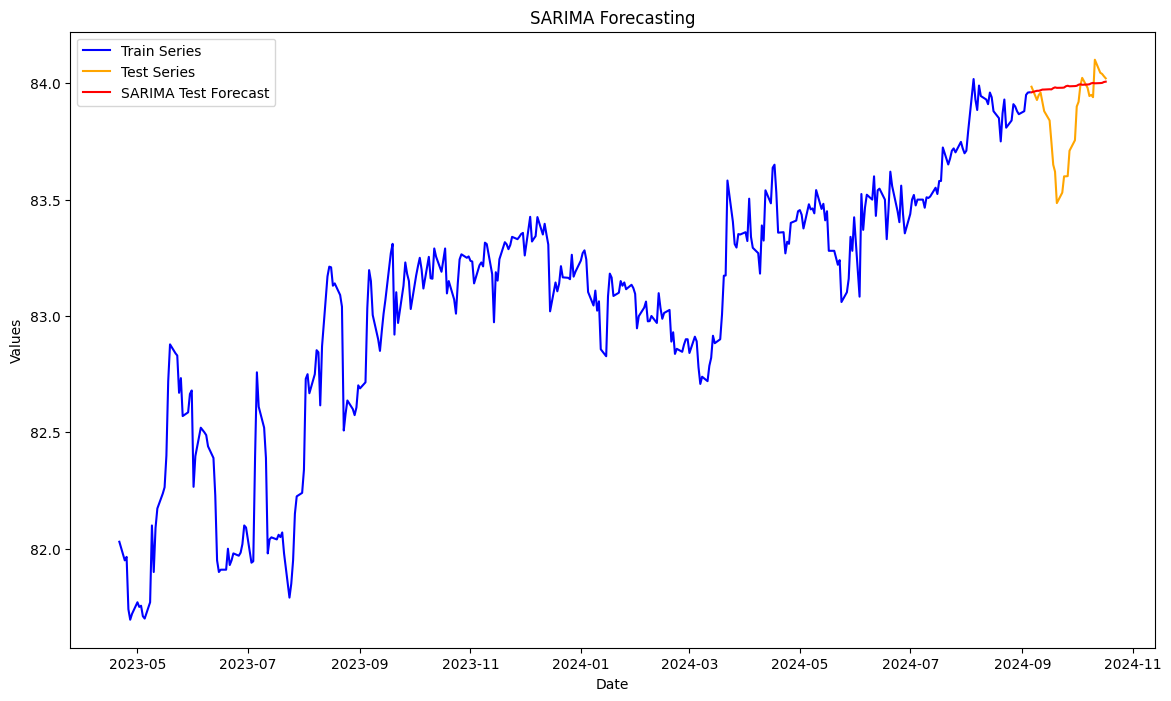

In [186]:
# Step 4: Plotting the Results
plt.figure(figsize=(14, 8))

# Plot the actual train and test series
plt.plot(train['Price'].index[-360:], train['Price'][-360:], label='Train Series', color='blue')
plt.plot(test['Price'].index, test['Price'], label='Test Series', color='orange')

# Forecast for the test period (out-of-sample forecast)
plt.plot(test['Price'].index, forecast, label='SARIMA Test Forecast', color='red')

# Labels and legend
plt.title("SARIMA Forecasting")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.show()

# GARCH Effect

In [198]:
# Step 1: Fit SARIMA model - best model: when m is 0
# Best model:  ARIMA(2,1,2)(0,0,0)[0] 
arima_model = SARIMAX(train['Price'], order=(2, 1, 2)).fit()
arima_forecast = arima_model.forecast(steps=len(test['Price']))

# Step 4: Evaluate the forecast
test_rmse = root_mean_squared_error(test['Price'], arima_forecast)
test_mae = mean_absolute_error(test['Price'], arima_forecast)
print(f'Test RMSE: {test_rmse}')
print(f'Test MAE: {test_mae}')


/home/harsh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/home/harsh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.01333D-02    |proj g|=  1.42007D-02


 This problem is unconstrained.



At iterate    5    f=  4.01100D-02    |proj g|=  5.29896D-03

At iterate   10    f=  4.00342D-02    |proj g|=  1.27071D-02

At iterate   15    f=  3.99144D-02    |proj g|=  1.84686D-03

At iterate   20    f=  3.98824D-02    |proj g|=  1.04078D-02

At iterate   25    f=  3.98512D-02    |proj g|=  1.24077D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     31      1     0     0   1.050D-04   3.985D-02
  F =   3.9851033234405975E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Test RMSE: 0.20492403202208107
Test MAE: 0.14507709162872498


In [199]:
arima_residuals = arima_model.resid  # Residuals from SARIMA model

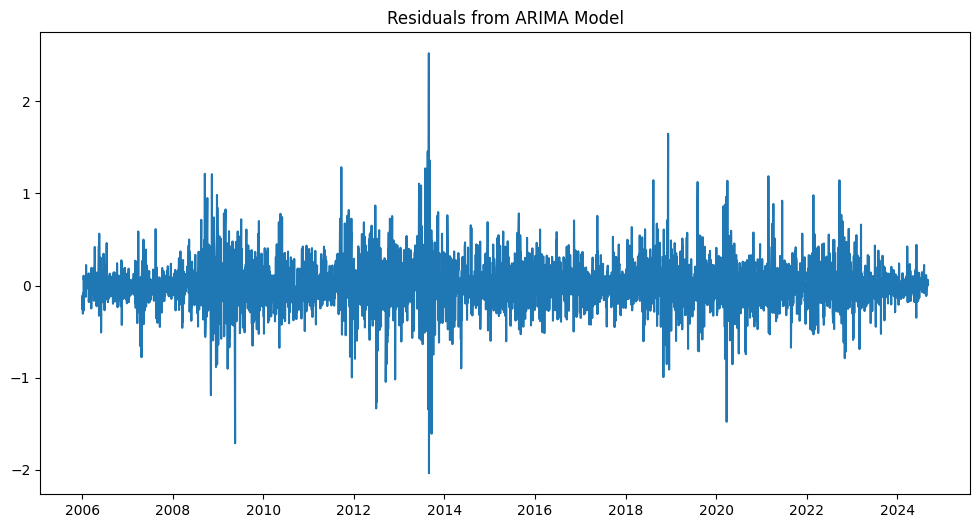

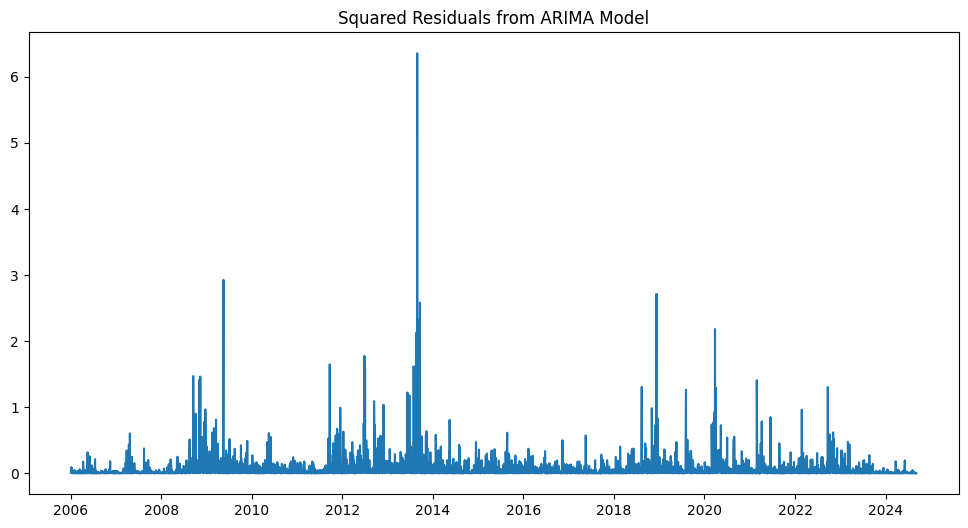

In [200]:
# Step 1: Plot residuals to visually inspect
plt.figure(figsize=(12, 6))
plt.plot(arima_residuals[1:])
plt.title("Residuals from ARIMA Model")
plt.show()

# Step 2: Plot squared residuals
plt.figure(figsize=(12, 6))
plt.plot(arima_residuals[1:] ** 2)
plt.title("Squared Residuals from ARIMA Model")
plt.show()


In [201]:
# Step 3: Perform ARCH-LM Test
arch_test = sm.stats.diagnostic.het_arch(arima_residuals)
print(f'ARCH-LM Test p-value: {arch_test[1]}')

# Step 4: Fit a GARCH model on residuals if p-value < 0.05 (indicating GARCH effects)
if arch_test[1] < 0.05:
    print("Significant GARCH effect found in residuals.")
    garch_model = arch_model(arima_residuals, vol='Garch', p=1, q=1)
    garch_fit = garch_model.fit(disp="off")
    print(garch_fit.summary())
else:
    print("No significant GARCH effect found in residuals.")

ARCH-LM Test p-value: 8.20888159089372e-176
Significant GARCH effect found in residuals.
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                294.946
Distribution:                  Normal   AIC:                          -581.892
Method:            Maximum Likelihood   BIC:                          -555.925
                                        No. Observations:                 4874
Date:                Sun, Nov 10 2024   Df Residuals:                     4873
Time:                        10:54:21   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------

In [208]:
# Step 1: Fit SARIMA model on the training set
arima_model = SARIMAX(train['Price'], order=(2, 1, 2)).fit()
arima_forecast = arima_model.get_forecast(steps=len(test['Price']))
arima_mean_forecast = arima_forecast.predicted_mean

print("Fitting GARCH model")
# Step 2: Fit GARCH model on SARIMA residuals
arima_residuals = arima_model.resid
garch_model = arch_model(arima_residuals, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp="off")

print("Generating GARCH forecast")
# Step 3: Forecast conditional variance from GARCH
garch_forecast = garch_fit.forecast(horizon=len(test['Price']))
garch_variance_forecast = garch_forecast.variance.values[-1, :]

# Step 4: Calculate confidence intervals
alpha = 0.05  # for 95% confidence interval
z_score = 1.96  # Z-score for 95% confidence
arima_forecast_upper = arima_mean_forecast + z_score * np.sqrt(garch_variance_forecast)
arima_forecast_lower = arima_mean_forecast - z_score * np.sqrt(garch_variance_forecast)

/home/harsh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/home/harsh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.01333D-02    |proj g|=  1.42007D-02


 This problem is unconstrained.



At iterate    5    f=  4.01100D-02    |proj g|=  5.29896D-03

At iterate   10    f=  4.00342D-02    |proj g|=  1.27071D-02

At iterate   15    f=  3.99144D-02    |proj g|=  1.84686D-03

At iterate   20    f=  3.98824D-02    |proj g|=  1.04078D-02

At iterate   25    f=  3.98512D-02    |proj g|=  1.24077D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     31      1     0     0   1.050D-04   3.985D-02
  F =   3.9851033234405975E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Fitting GARCH model
Generating GARCH forecast


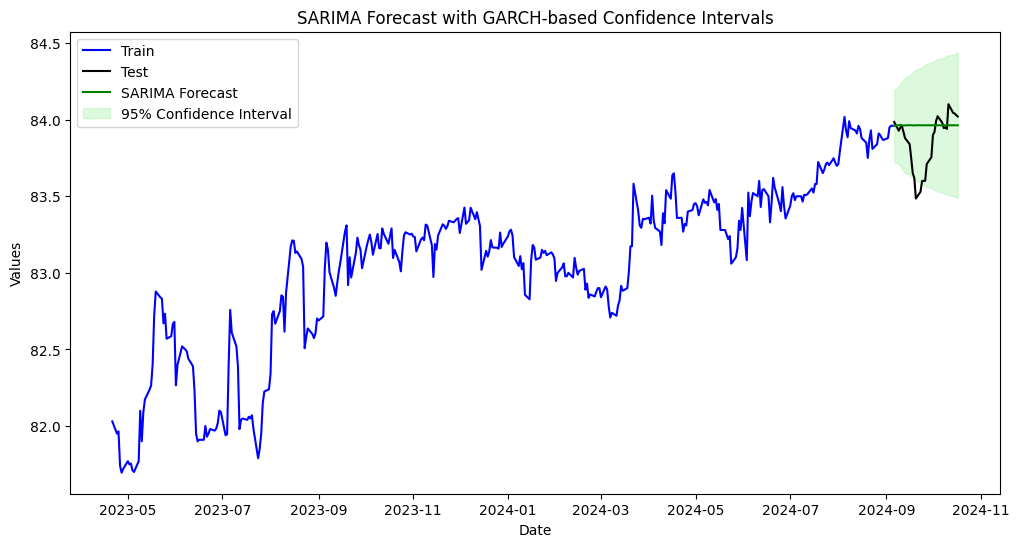

In [210]:
# Step 5: Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train['Price'].index[-360:], train['Price'][-360:], label="Train", color="blue")
plt.plot(test['Price'].index, test['Price'], label="Test", color="black")
plt.plot(test['Price'].index, arima_mean_forecast, label="SARIMA Forecast", color="green")
plt.fill_between(test['Price'].index, arima_forecast_lower, arima_forecast_upper, 
                 color="lightgreen", alpha=0.3, label="95% Confidence Interval")
plt.legend()
plt.title("SARIMA Forecast with GARCH-based Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Values")
plt.show()


# LSTM

In [56]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(exchange_data['Price'].values.reshape(-1, 1))


In [57]:
# Create Training and Testing Datasets
train_size_lstm = int(len(scaled_data) * 0.8)
train_lstm, test_lstm = scaled_data[:train_size_lstm], scaled_data[train_size_lstm:]


In [58]:
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [59]:

time_step = 60
# print(time_step)
X_train, y_train = create_dataset(train_lstm, time_step)
X_test, y_test = create_dataset(test_lstm, time_step)

# print(X_train.shape, X_test.shape)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [60]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dense(units=1))  # Output layer
lstm_model.compile(optimizer='adam', loss='mean_squared_error')


/home/harsh/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [61]:
# Model Summary
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32)


Epoch 1/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0242
Epoch 2/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 2.3185e-04
Epoch 3/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 2.4472e-04
Epoch 4/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 2.1056e-04
Epoch 5/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 2.2380e-04
Epoch 6/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 2.0949e-04
Epoch 7/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 1.9757e-04
Epoch 8/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 1.7267e-04
Epoch 9/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 1.7308e-04
Epoch 10/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 1.4595e-04
Epoch 11/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 1.7510e-04
Epoch 12/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 1.4023e-04
Epoch 13/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 1.4975e-04
Epoch 14/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/s

In [63]:
train_predict = lstm_model.predict(X_train)
test_predict = lstm_model.predict(X_test)

# Inverse transform to get actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Inverse transform y_train and y_test as well
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [64]:
train_rmse = np.sqrt(mean_squared_error(y_train_original, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_original, test_predict))
train_mae = mean_absolute_error(y_train_original, train_predict)
test_mae = mean_absolute_error(y_test_original, test_predict)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')


Train RMSE: 0.3175487010756935
Test RMSE: 0.5713827326262492
Train MAE: 0.23844477644317336
Test MAE: 0.5290194181359335


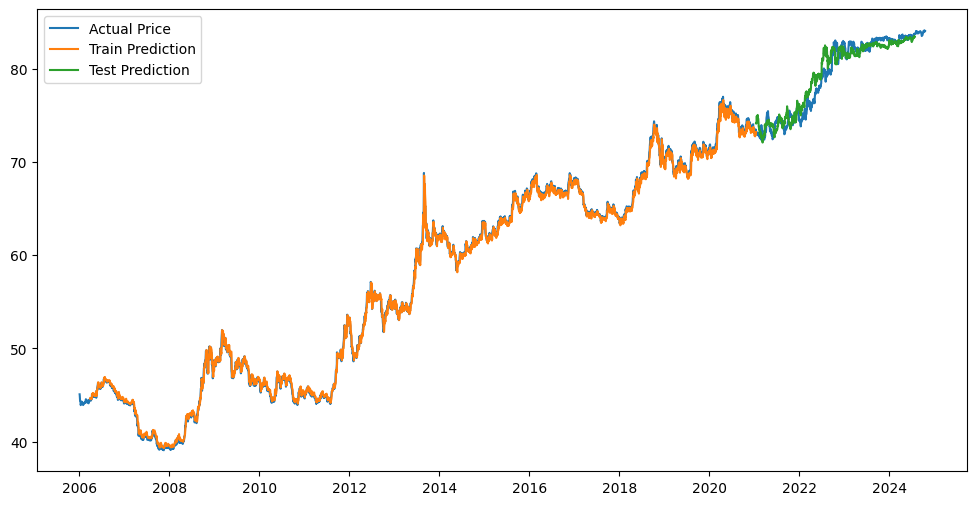

In [65]:
# print(train_predict.shape, y_train_original.shape)
# print(train_size_lstm)
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(exchange_data.index, exchange_data['Price'], label='Actual Price')
plt.plot(exchange_data.index[time_step+1:time_step+1+len(train_predict)], train_predict, label='Train Prediction')
plt.plot(exchange_data.index[time_step+1+len(train_predict):time_step+1+(len(train_predict) + len(test_predict))], test_predict, label='Test Prediction')
plt.legend()
plt.show()


In [66]:
# extract 30 days forecast and find forecast errors
test_rmse = root_mean_squared_error(y_test_original[-30:], test_predict[-30:])
test_mae = mean_absolute_error(y_test_original[-30:], test_predict[-30:])
print(f'Test RMSE: {test_rmse}')
print(f'Test MAE: {test_mae}')


Test RMSE: 0.648570258994011
Test MAE: 0.6448603617350254


In [81]:
lstm_model_predictions = test_predict[-30:]

# XGBoost

In [67]:
exchange_data_xgboost = exchange_data.copy()

In [68]:
# Since 'Date' is already set as the index and in datetime format, you can extract date-related features directly from the index.
exchange_data_xgboost['day'] = exchange_data_xgboost.index.day
exchange_data_xgboost['dayofweek'] = exchange_data_xgboost.index.dayofweek
exchange_data_xgboost['dayofyear'] = exchange_data_xgboost.index.dayofyear
exchange_data_xgboost['week'] = exchange_data_xgboost.index.isocalendar().week
exchange_data_xgboost['month'] = exchange_data_xgboost.index.month
exchange_data_xgboost['year'] = exchange_data_xgboost.index.year

In [69]:
# Generate lagged features for the target column, 'Price' in this case
for i in range(1, 8):  # Creates lag1 through lag7
    exchange_data_xgboost[f'lag_{i}'] = exchange_data_xgboost['Price'].shift(i).fillna(0)  # Shift and fill NaNs with 0

In [70]:
# Preserve 'Date' as a separate variable
dates = exchange_data_xgboost.index.copy()  # Since 'Date' is the index, no need to use the column

# Drop unnecessary columns
exchange_data_xgboost.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1, inplace=True)


In [71]:
print(exchange_data_xgboost.head(10))

             Price  day  dayofweek  dayofyear  week  month  year   lag_1  \
Date                                                                       
2006-01-02  45.075    2          0          2     1      1  2006   0.000   
2006-01-03  44.965    3          1          3     1      1  2006  45.075   
2006-01-04  44.705    4          2          4     1      1  2006  44.965   
2006-01-05  44.600    5          3          5     1      1  2006  44.705   
2006-01-06  44.320    6          4          6     1      1  2006  44.600   
2006-01-09  44.250    9          0          9     2      1  2006  44.320   
2006-01-10  44.185   10          1         10     2      1  2006  44.250   
2006-01-11  43.915   11          2         11     2      1  2006  44.185   
2006-01-12  44.020   12          3         12     2      1  2006  43.915   
2006-01-13  44.100   13          4         13     2      1  2006  44.020   

             lag_2   lag_3   lag_4   lag_5   lag_6   lag_7  
Date                      

In [72]:
# Define the features and target
features = exchange_data_xgboost.drop(columns=['Price'])
target = exchange_data_xgboost['Price']

# Test will be for 1 month forecast
train_size_xgboost = len(exchange_data_xgboost) - 30

# Split the data
X_train, X_test = features.iloc[:train_size_xgboost], features.iloc[train_size_xgboost:]
y_train, y_test = target.iloc[:train_size_xgboost], target.iloc[train_size_xgboost:]

In [73]:
#convert data to xgb matrix form
dtrain = xgb.DMatrix(X_train,label=y_train, feature_names=X_train.columns.tolist())
dtest = xgb.DMatrix(X_test, feature_names=X_test.columns.tolist())

In [74]:

# Convert to NumPy arrays
X_train_np = X_train.to_numpy() if hasattr(X_train, 'to_numpy') else X_train
y_train_np = y_train.to_numpy() if hasattr(y_train, 'to_numpy') else y_train

# Define time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Define the objective function for Bayesian optimization
def objective(params):
    n_estimators, max_depth, colsample_bytree, gamma, min_child_weight, reg_lambda, subsample = params
    
    # Define and train the XGBoost model
    model = xgb.XGBRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        min_child_weight=min_child_weight,
        reg_lambda=reg_lambda,
        subsample=subsample,
        random_state=42,
        objective="reg:squarederror"
    )
    
    # Time-series cross-validation scoring
    cv_scores = []
    for train_index, test_index in tscv.split(X_train_np):
        X_cv_train, X_cv_test = X_train_np[train_index], X_train_np[test_index]
        y_cv_train, y_cv_test = y_train_np[train_index], y_train_np[test_index]
        model.fit(X_cv_train, y_cv_train)
        y_pred = model.predict(X_cv_test)
        rmse = root_mean_squared_error(y_cv_test, y_pred)
        cv_scores.append(rmse)
    
    # Return the mean RMSE score across folds
    return np.mean(cv_scores)

# Define search space
space = [
    Integer(100, 1000, name="n_estimators"),
    Integer(1, 10, name="max_depth"),
    Real(0.5, 1.0, name="colsample_bytree"),
    Real(0.0, 1.0, name="gamma"),
    Integer(1, 10, name="min_child_weight"),
    Real(0.0, 1.0, name="reg_lambda"),
    Real(0.5, 1.0, name="subsample")
]

# Run Bayesian optimization
result = gp_minimize(objective, space, n_calls=30, random_state=42)

# Best hyperparameters and score
print("Best parameters:", result.x)
print("Best score (RMSE):", result.fun)

Best parameters: [709, 1, 0.9574122087008856, 0.029589842454099045, 5, 0.4547786868985657, 0.8639325805370518]
Best score (RMSE): 3.7107553520019514


In [75]:
# Extract the best parameters
best_params = result.x

# Create the final model with the best parameters
xgboost_model = xgb.XGBRegressor(
    n_estimators=int(best_params[0]),
    max_depth=int(best_params[1]),
    colsample_bytree=best_params[2],
    gamma=best_params[3],
    min_child_weight=best_params[4],
    reg_lambda=best_params[5],
    subsample=best_params[6],
    random_state=42,
    objective="reg:squarederror"
)

# Fit the model on the full training dataset
xgboost_model.fit(X_train_np, y_train_np)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9574122087008856, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.029589842454099045,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=709, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [76]:

# Make predictions
train_predictions = xgboost_model.predict(X_train)
test_predictions = xgboost_model.predict(X_test)


In [77]:
# Evaluate the model using RMSE, MAE, or any other metrics
test_rmse = root_mean_squared_error(y_test, test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
train_rmse = root_mean_squared_error(y_train, train_predictions)
train_mae = mean_absolute_error(y_train, train_predictions)


print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)

Train RMSE: 0.5445737405331663
Test RMSE: 0.23949066040844616
Train MAE: 0.37731439327949085
Test MAE: 0.2084165079752599


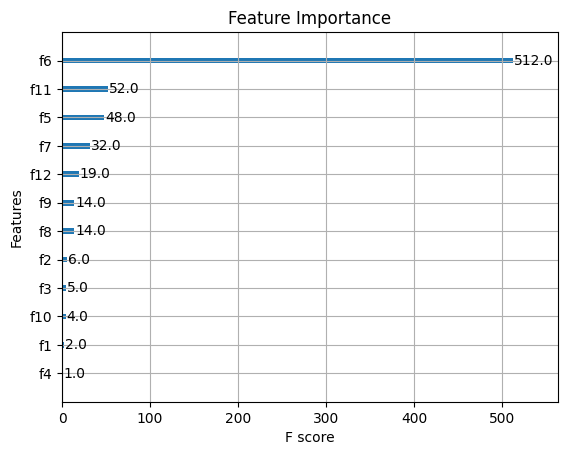

In [78]:
# Plot feature importance
xgb.plot_importance(xgboost_model, importance_type='weight')
plt.title("Feature Importance")
plt.show()

In [79]:
# Get feature importances
importance = xgboost_model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance DataFrame
print(importance_df)

      Feature  Importance
11      lag_6    0.721740
6       lag_1    0.103946
9       lag_4    0.089351
5        year    0.048397
10      lag_5    0.032096
7       lag_2    0.001930
4       month    0.001159
2   dayofyear    0.000371
12      lag_7    0.000347
8       lag_3    0.000270
3        week    0.000217
1   dayofweek    0.000177
0         day    0.000000


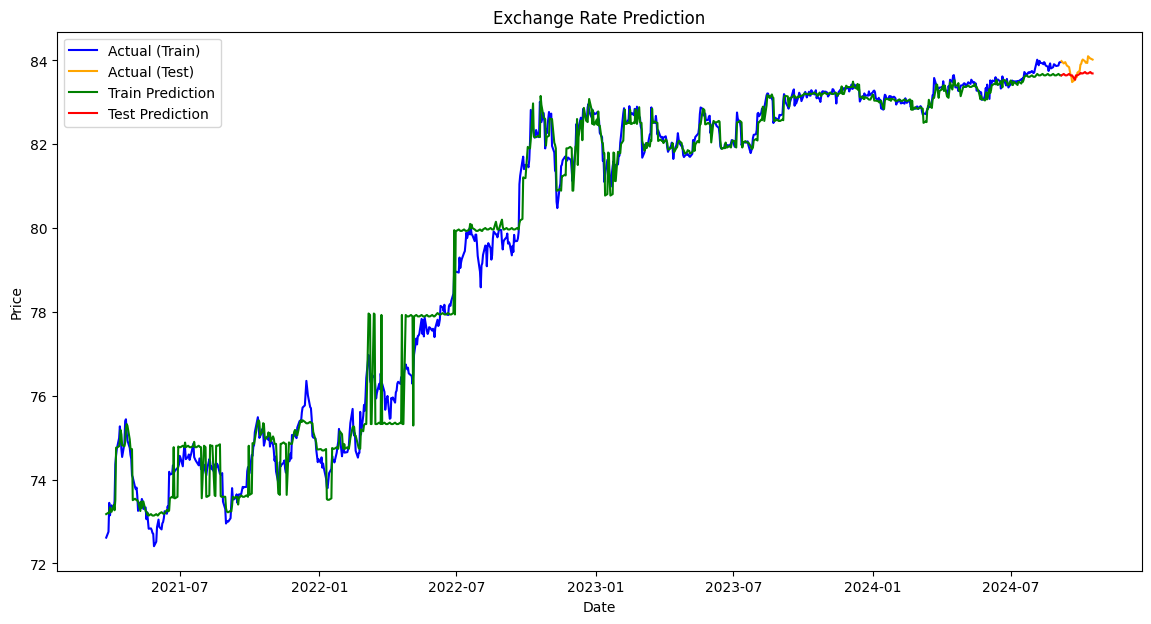

In [80]:
# # Ensure you have the dates corresponding to your training and testing data
train_dates = dates[:train_size_xgboost]  # The dates for training data
test_dates = dates[train_size_xgboost:]  # The dates for testing data

# Plot actual vs predictions
plt.figure(figsize=(14, 7))
plt.plot(train_dates[-900:], y_train[-900:], label='Actual (Train)', color='blue')
plt.plot(test_dates, y_test, label='Actual (Test)', color='orange')
plt.plot(train_dates[-900:], train_predictions[-900:], label='Train Prediction', color='green')
plt.plot(test_dates, test_predictions, label='Test Prediction', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Exchange Rate Prediction')
plt.legend()
plt.show()

In [82]:
xgboost_model_predictions = test_predictions

# ensemble - Weighted Average Ensemble

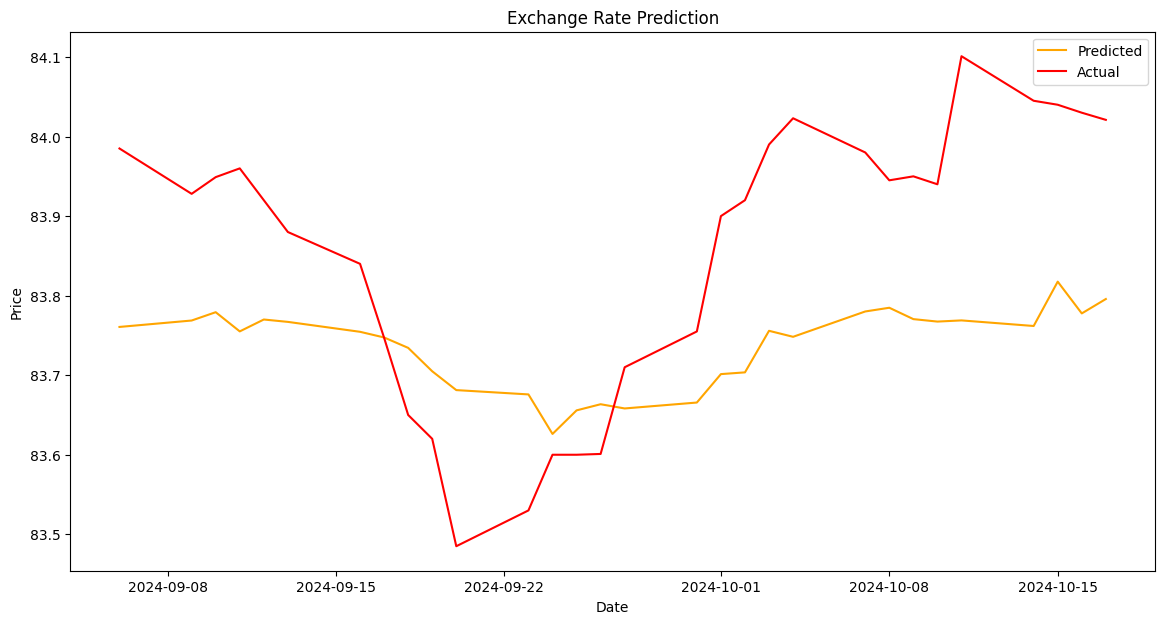

Forecast RMSE:  0.18075305274362316
Forecast MAE:  0.16185177302075385


In [119]:
weights = [0.7, 0.2, 0.1]     
# print(arima_model_predictions.shape, lstm_model_predictions.shape, xgboost_model_predictions.shape)
ensemble_predictions = [arima_model_predictions, lstm_model_predictions.flatten(), xgboost_model_predictions]

# Combine the predictions using weighted average
ensemble_preds = (weights[0] * ensemble_predictions[0]) + (weights[1] * ensemble_predictions[1]) + (weights[2] * ensemble_predictions[1])

# Now you have the ensemble predictions
# print(ensemble_preds)
# Plot actual vs predictions
plt.figure(figsize=(14, 7))
# plt.plot(train_dates, y_train, label='Actual (Train)', color='blue')
plt.plot(test_dates, ensemble_preds, label='Predicted', color='orange')
# plt.plot(train_dates, train_predictions, label='Train Prediction', color='green')
plt.plot(test_dates, test['Price'], label='Actual', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Exchange Rate Prediction')
plt.legend()
plt.show()

test_rmse = root_mean_squared_error(test['Price'], ensemble_preds)
test_mae = mean_absolute_error(test['Price'], ensemble_preds)
print("Forecast RMSE: ", test_rmse)
print("Forecast MAE: ", test_mae)